# Credit 

- https://www.kaggle.com/itratrahman/nlp-tutorial-using-python

In [1]:

# OP 
import pandas as pd
import numpy as np
import time
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

%matplotlib inline
%pylab inline
import seaborn  as sns 
from matplotlib import pyplot
import matplotlib.pyplot as plt


Populating the interactive namespace from numpy and matplotlib


In [2]:
# set plot style
matplotlib.style.use('fivethirtyeight')
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (10,10)

## 0) Load data 

In [3]:
# help fun 

def get_sentence_length(x):
    return len(x)

def remove_punctuation(text):
    '''a function for removing punctuation'''
    import string
    # replacing the punctuations with no space, 
    # which in effect deletes the punctuation marks 
    translator = str.maketrans('', '', string.punctuation)
    # return the text stripped of punctuation marks
    return text.translate(translator)


# stop words : show stop words in English 


def stopwords_(text):
    '''a function for removing the stopword'''
    # removing the stop words and lowercasing the selected words
    sw = stopwords.words('english')
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)


# create an object of stemming function
stemmer = SnowballStemmer("english")
def stemming(text):    
    '''a function which stems each word in the given text'''
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text) 

In [4]:
# LOAD THE DATA 

df = pd.read_csv('spam.csv', delimiter=',',encoding='latin-1')
df = df.loc[:,['v1','v2']]

# get feature

df['length'] = df['v2'].apply(get_sentence_length)
# remove punctuation
df['v2_del_punct'] = df['v2'].apply(remove_punctuation)
# remove stopwords
df['v2_del_stopword'] = df['v2'].apply(stopwords_)
# get stem
df['v2_stemming'] = df['v2'].apply(stemming)


df.head()

,v1,v2,length,v2_del_punct,v2_del_stopword,v2_stemming
0,ham,"Go until jurong point, crazy.. Available only ...",111,Go until jurong point crazy Available only in ...,"go jurong point, crazy.. available bugis n gre...","go until jurong point, crazy.. avail onli in b..."
1,ham,Ok lar... Joking wif u oni...,29,Ok lar Joking wif u oni,ok lar... joking wif u oni...,ok lar... joke wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,free entri in 2 a wkli comp to win fa cup fina...
3,ham,U dun say so early hor... U c already then say...,49,U dun say so early hor U c already then say,u dun say early hor... u c already say...,u dun say so earli hor... u c alreadi then say...
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,Nah I dont think he goes to usf he lives aroun...,"nah think goes usf, lives around though","nah i don't think he goe to usf, he live aroun..."


## 1) Data Overview

Text(0.5,1,'Sentence Length Histagram')

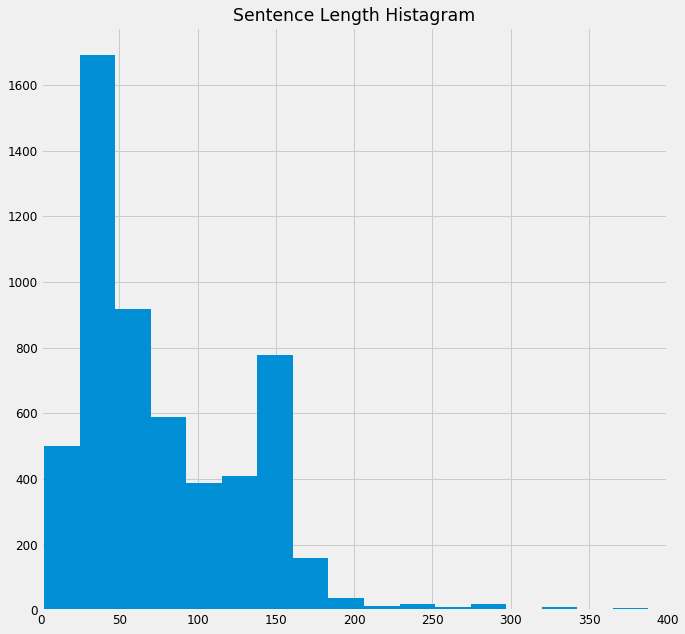

In [5]:
# sentence length hist 

df.length.hist(bins=40)
plt.xlim(0,400)
plt.title('Sentence Length Histagram')

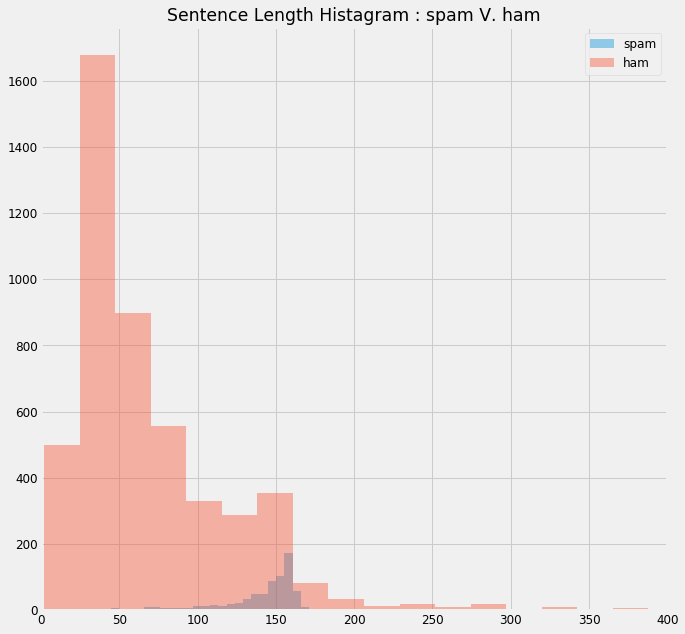

In [6]:
# sentence length hist  with spam V. ham

df[df.v1 == 'spam' ].length.hist(bins=40,alpha = 0.4)
df[df.v1 == 'ham' ].length.hist(bins=40,alpha = 0.4)
plt.xlim(0,400)
plt.title('Sentence Length Histagram : spam V. ham')
plt.legend(['spam','ham'])
plt.show()

In [7]:
X = df.v2
Y = df.v1
le = LabelEncoder()
Y = le.fit_transform(Y)

In [8]:
Y.shape

(5572,)

In [9]:
pd.DataFrame(Y)[0].value_counts()

0    4825
1     747
Name: 0, dtype: int64

In [10]:
X.iloc[0]

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [11]:
X.iloc[1]

'Ok lar... Joking wif u oni...'

## 1) NLP feature extract 

In [12]:
stopwords

<WordListCorpusReader in '/Users/yennanliu/nltk_data/corpora/stopwords'>

In [13]:
#print("Number of stopwords: ", len(sw))

In [14]:
df.head()

,v1,v2,length,v2_del_punct,v2_del_stopword,v2_stemming
0,ham,"Go until jurong point, crazy.. Available only ...",111,Go until jurong point crazy Available only in ...,"go jurong point, crazy.. available bugis n gre...","go until jurong point, crazy.. avail onli in b..."
1,ham,Ok lar... Joking wif u oni...,29,Ok lar Joking wif u oni,ok lar... joking wif u oni...,ok lar... joke wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,free entri in 2 a wkli comp to win fa cup fina...
3,ham,U dun say so early hor... U c already then say...,49,U dun say so early hor U c already then say,u dun say early hor... u c already say...,u dun say so earli hor... u c alreadi then say...
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,Nah I dont think he goes to usf he lives aroun...,"nah think goes usf, lives around though","nah i don't think he goe to usf, he live aroun..."


In [15]:
# Collect vocabulary count


# create a count vectorizer object
count_vectorizer = CountVectorizer()
# fit the count vectorizer using the text data
count_vectorizer.fit(df['v2_del_stopword'])
# collect the vocabulary items used in the vectorizer
dictionary = count_vectorizer.vocabulary_.items()

# lists to store the vocab and counts
vocab = []
count = []
# iterate through each vocab and count append the value to designated lists
for key, value in dictionary:
    vocab.append(key)
    count.append(value)
# store the count in panadas dataframe with vocab as index
vocab_bef_stem = pd.Series(count, index=vocab)
# sort the dataframe
vocab_bef_stem = vocab_bef_stem.sort_values(ascending=False)

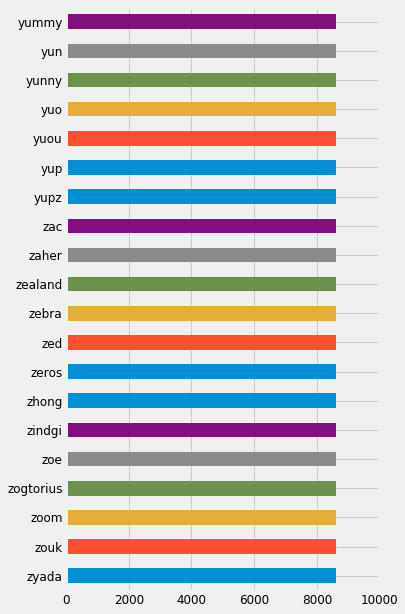

In [16]:
# plot top vacab.

top_vacab = vocab_bef_stem[20:40]
top_vacab.plot(kind = 'barh', figsize=(5,10), xlim= (0, 10000))

In [17]:
# stemming ops 
# run stemming operation 

print ('stemming words :  ')
print ('-'*10)
print ('')
print (df['v2_stemming'].head(5))
print ('-'*10)
print ('original words :  ')
df['v2'].head(5)

stemming words :  
----------

0    go until jurong point, crazy.. avail onli in b...
1                          ok lar... joke wif u oni...
2    free entri in 2 a wkli comp to win fa cup fina...
3    u dun say so earli hor... u c alreadi then say...
4    nah i don't think he goe to usf, he live aroun...
Name: v2_stemming, dtype: object
----------
original words :  


0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
Name: v2, dtype: object